# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

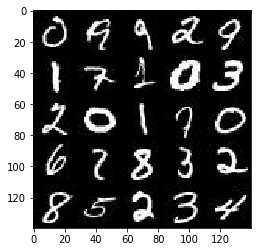

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

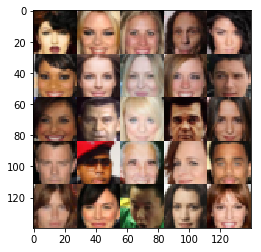

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [34]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input');
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [35]:
def leak_relu(x, multiplier=0.1):
    '''
    x: Tensor
    multiplier: leak multiplier 
    
    Returns max tensor on input tensor. 
    '''
    return tf.maximum(x, x * multiplier)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        layer = tf.layers.conv2d(images, 
                                 64, 
                                 3, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        
        
        # Image 7x7x128 
        layer = tf.layers.conv2d(layer, 
                                 128, 
                                 3, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        

        # Image 4x4x25
        layer = tf.layers.conv2d(layer, 
                                 256, 
                                 3, 
                                 strides=2,
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        

        flat = tf.reshape(layer, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train = True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        
        # Image 7x7x1024
        layer = tf.layers.dense(z, 7*7*1024)
        layer = tf.reshape(layer, (-1, 7, 7, 1024))
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)
        
        # Image 14x14x512
        layer = tf.layers.conv2d_transpose(layer, 512, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        relu = tf.nn.relu(layer)
         
        # Image 28x28x256
        layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 3, strides=2, padding='same')
        layer = tf.image.resize_images(layer, size=(28, 28)) 
        
        output = tf.nn.tanh(layer, name='generator_main')
        
    return output
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_train = True)
    
    discriminator_real_model, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    smooth = 0.1
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits,
                                                                         labels=tf.ones_like(discriminator_real_model) * (1 - smooth)))
    
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                         labels=tf.zeros_like(discriminator_fake_model)))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                    labels = tf.ones_like(discriminator_fake_model)))
    
    return discriminator_loss, generator_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
    discriminator_ops = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, 
                                                                                                      var_list = discriminator_vars)
    generator_ops = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, 
                                                                                         var_list = generator_vars)
    
    return discriminator_ops, generator_ops



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_ops, g_ops = model_opt(d_loss, g_loss, lr, beta1)
    
    batch = 0;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch += 1

                # since discriminator expects values from -1 to 1  
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(g_ops, feed_dict = {
                    lr :learning_rate,
                    z_input : batch_z,
                })
                
                sess.run(d_ops, feed_dict = {
                    lr : learning_rate,
                    real_input : batch_images, 
                    z_input : batch_z
                })
                
                
                if batch % 10 == 0:
                    # run losses. 
                    train_loss_d = sess.run(d_loss, feed_dict = { real_input : batch_images, z_input : batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict =  { z_input : batch_z})
                    print("Epoch {}/{}... Step {}...".format(epoch_i+1, epochs, batch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    
                if batch % 100 == 0:
                    print("Sample Outputs....")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10... Discriminator Loss: 12.8824... Generator Loss: 35.0241
Epoch 1/2... Step 20... Discriminator Loss: 1.1152... Generator Loss: 1.0573
Epoch 1/2... Step 30... Discriminator Loss: 0.4838... Generator Loss: 2.9886
Epoch 1/2... Step 40... Discriminator Loss: 2.3076... Generator Loss: 0.2555
Epoch 1/2... Step 50... Discriminator Loss: 1.6411... Generator Loss: 0.4736
Epoch 1/2... Step 60... Discriminator Loss: 1.5799... Generator Loss: 0.4296
Epoch 1/2... Step 70... Discriminator Loss: 1.4801... Generator Loss: 0.4618
Epoch 1/2... Step 80... Discriminator Loss: 1.4734... Generator Loss: 0.4827
Epoch 1/2... Step 90... Discriminator Loss: 1.4128... Generator Loss: 0.4993
Epoch 1/2... Step 100... Discriminator Loss: 1.3022... Generator Loss: 0.5683
Sample Outputs....


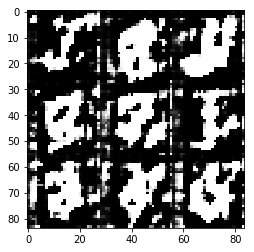

Epoch 1/2... Step 110... Discriminator Loss: 1.2257... Generator Loss: 0.6348
Epoch 1/2... Step 120... Discriminator Loss: 1.2766... Generator Loss: 0.5932
Epoch 1/2... Step 130... Discriminator Loss: 1.3087... Generator Loss: 0.5025
Epoch 1/2... Step 140... Discriminator Loss: 1.1653... Generator Loss: 0.6402
Epoch 1/2... Step 150... Discriminator Loss: 0.9621... Generator Loss: 0.8747
Epoch 1/2... Step 160... Discriminator Loss: 0.8593... Generator Loss: 1.4147
Epoch 1/2... Step 170... Discriminator Loss: 1.0723... Generator Loss: 0.9507
Epoch 1/2... Step 180... Discriminator Loss: 1.1271... Generator Loss: 0.8220
Epoch 1/2... Step 190... Discriminator Loss: 0.7878... Generator Loss: 1.4516
Epoch 1/2... Step 200... Discriminator Loss: 0.8323... Generator Loss: 2.6731
Sample Outputs....


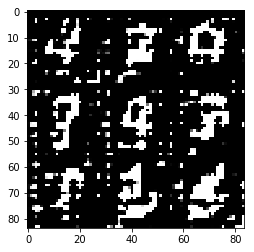

Epoch 1/2... Step 210... Discriminator Loss: 1.1006... Generator Loss: 0.7152
Epoch 1/2... Step 220... Discriminator Loss: 0.6933... Generator Loss: 1.4029
Epoch 1/2... Step 230... Discriminator Loss: 1.0399... Generator Loss: 1.9637
Epoch 1/2... Step 240... Discriminator Loss: 0.6847... Generator Loss: 3.2371
Epoch 1/2... Step 250... Discriminator Loss: 0.8180... Generator Loss: 1.4151
Epoch 1/2... Step 260... Discriminator Loss: 0.9715... Generator Loss: 3.9129
Epoch 1/2... Step 270... Discriminator Loss: 0.6579... Generator Loss: 2.0972
Epoch 1/2... Step 280... Discriminator Loss: 0.7487... Generator Loss: 3.2767
Epoch 1/2... Step 290... Discriminator Loss: 0.6536... Generator Loss: 1.8443
Epoch 1/2... Step 300... Discriminator Loss: 1.8346... Generator Loss: 4.0119
Sample Outputs....


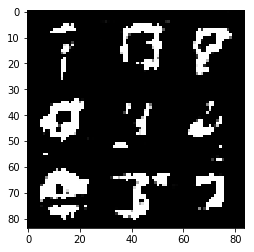

Epoch 1/2... Step 310... Discriminator Loss: 0.9154... Generator Loss: 1.7695
Epoch 1/2... Step 320... Discriminator Loss: 1.0663... Generator Loss: 1.3133
Epoch 1/2... Step 330... Discriminator Loss: 1.3742... Generator Loss: 2.2034
Epoch 1/2... Step 340... Discriminator Loss: 1.1628... Generator Loss: 1.9084
Epoch 1/2... Step 350... Discriminator Loss: 1.0106... Generator Loss: 1.4932
Epoch 1/2... Step 360... Discriminator Loss: 1.0687... Generator Loss: 1.3979
Epoch 1/2... Step 370... Discriminator Loss: 0.9594... Generator Loss: 0.9650
Epoch 1/2... Step 380... Discriminator Loss: 1.5361... Generator Loss: 2.0254
Epoch 1/2... Step 390... Discriminator Loss: 1.1264... Generator Loss: 1.3508
Epoch 1/2... Step 400... Discriminator Loss: 1.1047... Generator Loss: 1.2881
Sample Outputs....


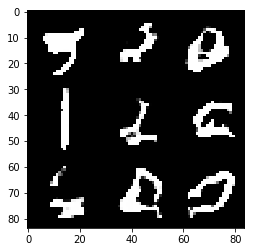

Epoch 1/2... Step 410... Discriminator Loss: 1.1424... Generator Loss: 1.5635
Epoch 1/2... Step 420... Discriminator Loss: 1.0458... Generator Loss: 1.0490
Epoch 1/2... Step 430... Discriminator Loss: 1.0666... Generator Loss: 1.0014
Epoch 1/2... Step 440... Discriminator Loss: 0.9859... Generator Loss: 1.0668
Epoch 1/2... Step 450... Discriminator Loss: 1.1595... Generator Loss: 0.7745
Epoch 1/2... Step 460... Discriminator Loss: 1.1015... Generator Loss: 1.0476
Epoch 2/2... Step 470... Discriminator Loss: 1.1877... Generator Loss: 1.5811
Epoch 2/2... Step 480... Discriminator Loss: 1.0928... Generator Loss: 1.2560
Epoch 2/2... Step 490... Discriminator Loss: 1.1571... Generator Loss: 0.6577
Epoch 2/2... Step 500... Discriminator Loss: 1.0558... Generator Loss: 1.0425
Sample Outputs....


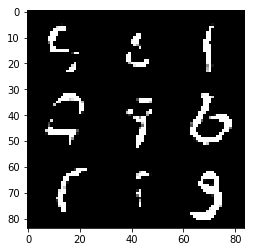

Epoch 2/2... Step 510... Discriminator Loss: 1.0858... Generator Loss: 0.8406
Epoch 2/2... Step 520... Discriminator Loss: 0.8856... Generator Loss: 1.1346
Epoch 2/2... Step 530... Discriminator Loss: 1.0334... Generator Loss: 0.9809
Epoch 2/2... Step 540... Discriminator Loss: 0.9862... Generator Loss: 1.2062
Epoch 2/2... Step 550... Discriminator Loss: 1.3130... Generator Loss: 0.6405
Epoch 2/2... Step 560... Discriminator Loss: 1.1390... Generator Loss: 1.0450
Epoch 2/2... Step 570... Discriminator Loss: 0.8679... Generator Loss: 1.3702
Epoch 2/2... Step 580... Discriminator Loss: 1.2027... Generator Loss: 1.1377
Epoch 2/2... Step 590... Discriminator Loss: 1.0594... Generator Loss: 1.5253
Epoch 2/2... Step 600... Discriminator Loss: 0.9560... Generator Loss: 1.5019
Sample Outputs....


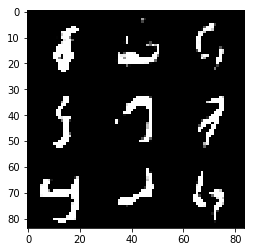

Epoch 2/2... Step 610... Discriminator Loss: 1.1605... Generator Loss: 0.8147
Epoch 2/2... Step 620... Discriminator Loss: 1.0007... Generator Loss: 0.9653
Epoch 2/2... Step 630... Discriminator Loss: 1.2802... Generator Loss: 1.6917
Epoch 2/2... Step 640... Discriminator Loss: 1.0963... Generator Loss: 1.8727
Epoch 2/2... Step 650... Discriminator Loss: 1.1420... Generator Loss: 1.2797
Epoch 2/2... Step 660... Discriminator Loss: 0.9758... Generator Loss: 1.6386
Epoch 2/2... Step 670... Discriminator Loss: 0.9522... Generator Loss: 0.8800
Epoch 2/2... Step 680... Discriminator Loss: 0.7798... Generator Loss: 1.5111
Epoch 2/2... Step 690... Discriminator Loss: 1.1213... Generator Loss: 1.8076
Epoch 2/2... Step 700... Discriminator Loss: 1.0828... Generator Loss: 1.0049
Sample Outputs....


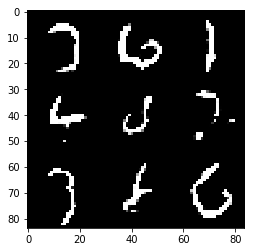

Epoch 2/2... Step 710... Discriminator Loss: 1.2015... Generator Loss: 0.7043
Epoch 2/2... Step 720... Discriminator Loss: 0.9679... Generator Loss: 1.0967
Epoch 2/2... Step 730... Discriminator Loss: 0.6650... Generator Loss: 1.8695
Epoch 2/2... Step 740... Discriminator Loss: 1.1589... Generator Loss: 0.6895
Epoch 2/2... Step 750... Discriminator Loss: 0.8727... Generator Loss: 1.9237
Epoch 2/2... Step 760... Discriminator Loss: 1.4519... Generator Loss: 0.4455
Epoch 2/2... Step 770... Discriminator Loss: 0.5901... Generator Loss: 2.6882
Epoch 2/2... Step 780... Discriminator Loss: 1.3379... Generator Loss: 1.8161
Epoch 2/2... Step 790... Discriminator Loss: 2.0036... Generator Loss: 2.6196
Epoch 2/2... Step 800... Discriminator Loss: 0.7916... Generator Loss: 2.8744
Sample Outputs....


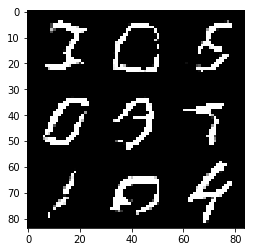

Epoch 2/2... Step 810... Discriminator Loss: 0.5001... Generator Loss: 2.6106
Epoch 2/2... Step 820... Discriminator Loss: 1.6436... Generator Loss: 2.8864
Epoch 2/2... Step 830... Discriminator Loss: 1.1334... Generator Loss: 1.0177
Epoch 2/2... Step 840... Discriminator Loss: 1.1330... Generator Loss: 0.7693
Epoch 2/2... Step 850... Discriminator Loss: 1.1827... Generator Loss: 0.7476
Epoch 2/2... Step 860... Discriminator Loss: 1.1055... Generator Loss: 0.9084
Epoch 2/2... Step 870... Discriminator Loss: 1.2681... Generator Loss: 0.6332
Epoch 2/2... Step 880... Discriminator Loss: 1.1199... Generator Loss: 0.9561
Epoch 2/2... Step 890... Discriminator Loss: 0.5928... Generator Loss: 2.0683
Epoch 2/2... Step 900... Discriminator Loss: 0.7583... Generator Loss: 1.5110
Sample Outputs....


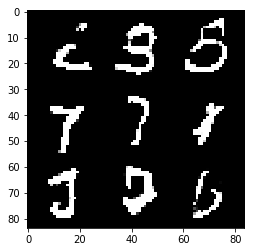

Epoch 2/2... Step 910... Discriminator Loss: 0.9095... Generator Loss: 1.2990
Epoch 2/2... Step 920... Discriminator Loss: 0.5035... Generator Loss: 2.0228
Epoch 2/2... Step 930... Discriminator Loss: 0.6839... Generator Loss: 1.7042


In [42]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.2
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10... Discriminator Loss: 0.8558... Generator Loss: 8.5399
Epoch 1/1... Step 20... Discriminator Loss: 0.7568... Generator Loss: 18.3178
Epoch 1/1... Step 30... Discriminator Loss: 0.6884... Generator Loss: 12.5071
Epoch 1/1... Step 40... Discriminator Loss: 0.4307... Generator Loss: 5.0224
Epoch 1/1... Step 50... Discriminator Loss: 0.6428... Generator Loss: 12.4983
Epoch 1/1... Step 60... Discriminator Loss: 6.2568... Generator Loss: 21.8605
Epoch 1/1... Step 70... Discriminator Loss: 1.1145... Generator Loss: 1.2603
Epoch 1/1... Step 80... Discriminator Loss: 2.7547... Generator Loss: 6.5097
Epoch 1/1... Step 90... Discriminator Loss: 2.1431... Generator Loss: 5.7016
Epoch 1/1... Step 100... Discriminator Loss: 0.4459... Generator Loss: 3.4914
Sample Outputs....


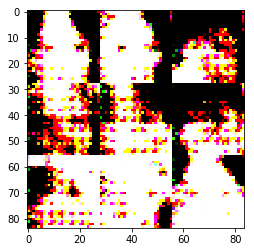

Epoch 1/1... Step 110... Discriminator Loss: 1.2647... Generator Loss: 0.9898
Epoch 1/1... Step 120... Discriminator Loss: 0.4075... Generator Loss: 3.4919
Epoch 1/1... Step 130... Discriminator Loss: 1.2369... Generator Loss: 7.0402
Epoch 1/1... Step 140... Discriminator Loss: 0.9474... Generator Loss: 2.9303
Epoch 1/1... Step 150... Discriminator Loss: 1.2592... Generator Loss: 0.8237
Epoch 1/1... Step 160... Discriminator Loss: 1.1108... Generator Loss: 0.7775
Epoch 1/1... Step 170... Discriminator Loss: 0.9583... Generator Loss: 0.9360
Epoch 1/1... Step 180... Discriminator Loss: 1.2459... Generator Loss: 1.1104
Epoch 1/1... Step 190... Discriminator Loss: 1.0407... Generator Loss: 0.8963
Epoch 1/1... Step 200... Discriminator Loss: 0.8916... Generator Loss: 1.0790
Sample Outputs....


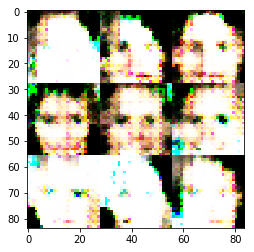

Epoch 1/1... Step 210... Discriminator Loss: 1.0358... Generator Loss: 0.9643
Epoch 1/1... Step 220... Discriminator Loss: 1.2338... Generator Loss: 1.6648
Epoch 1/1... Step 230... Discriminator Loss: 1.6662... Generator Loss: 2.0135
Epoch 1/1... Step 240... Discriminator Loss: 1.1843... Generator Loss: 1.0286
Epoch 1/1... Step 250... Discriminator Loss: 1.2250... Generator Loss: 1.1246
Epoch 1/1... Step 260... Discriminator Loss: 1.0921... Generator Loss: 1.0586
Epoch 1/1... Step 270... Discriminator Loss: 1.2842... Generator Loss: 1.0469
Epoch 1/1... Step 280... Discriminator Loss: 1.2189... Generator Loss: 1.2255
Epoch 1/1... Step 290... Discriminator Loss: 1.3122... Generator Loss: 0.6027
Epoch 1/1... Step 300... Discriminator Loss: 1.1121... Generator Loss: 0.7471
Sample Outputs....


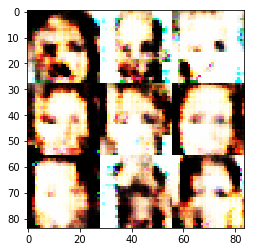

Epoch 1/1... Step 310... Discriminator Loss: 1.1054... Generator Loss: 1.0248
Epoch 1/1... Step 320... Discriminator Loss: 1.2414... Generator Loss: 1.0192
Epoch 1/1... Step 330... Discriminator Loss: 1.2148... Generator Loss: 1.0049
Epoch 1/1... Step 340... Discriminator Loss: 1.2072... Generator Loss: 0.8198
Epoch 1/1... Step 350... Discriminator Loss: 1.2521... Generator Loss: 4.0818
Epoch 1/1... Step 360... Discriminator Loss: 1.4703... Generator Loss: 2.2964
Epoch 1/1... Step 370... Discriminator Loss: 1.1731... Generator Loss: 1.5005
Epoch 1/1... Step 380... Discriminator Loss: 1.1465... Generator Loss: 0.9155
Epoch 1/1... Step 390... Discriminator Loss: 1.2674... Generator Loss: 0.9217
Epoch 1/1... Step 400... Discriminator Loss: 1.2021... Generator Loss: 0.8666
Sample Outputs....


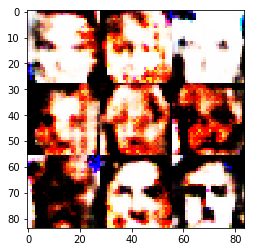

Epoch 1/1... Step 410... Discriminator Loss: 1.2122... Generator Loss: 0.8454
Epoch 1/1... Step 420... Discriminator Loss: 1.2669... Generator Loss: 1.3363
Epoch 1/1... Step 430... Discriminator Loss: 1.1899... Generator Loss: 0.8137
Epoch 1/1... Step 440... Discriminator Loss: 1.1754... Generator Loss: 0.7325
Epoch 1/1... Step 450... Discriminator Loss: 1.5314... Generator Loss: 2.0304
Epoch 1/1... Step 460... Discriminator Loss: 1.2189... Generator Loss: 0.8099
Epoch 1/1... Step 470... Discriminator Loss: 1.2368... Generator Loss: 1.3585
Epoch 1/1... Step 480... Discriminator Loss: 1.3726... Generator Loss: 1.2866
Epoch 1/1... Step 490... Discriminator Loss: 1.2096... Generator Loss: 0.8838
Epoch 1/1... Step 500... Discriminator Loss: 1.1853... Generator Loss: 1.4090
Sample Outputs....


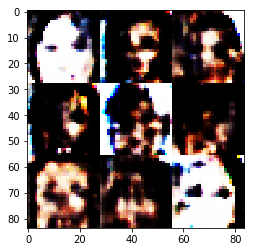

Epoch 1/1... Step 510... Discriminator Loss: 1.2437... Generator Loss: 0.8262
Epoch 1/1... Step 520... Discriminator Loss: 1.2667... Generator Loss: 1.1340
Epoch 1/1... Step 530... Discriminator Loss: 1.2056... Generator Loss: 0.8481
Epoch 1/1... Step 540... Discriminator Loss: 1.2904... Generator Loss: 1.0635
Epoch 1/1... Step 550... Discriminator Loss: 1.1203... Generator Loss: 1.2338
Epoch 1/1... Step 560... Discriminator Loss: 1.2936... Generator Loss: 0.9264
Epoch 1/1... Step 570... Discriminator Loss: 1.2384... Generator Loss: 0.8918
Epoch 1/1... Step 580... Discriminator Loss: 1.2981... Generator Loss: 0.8807
Epoch 1/1... Step 590... Discriminator Loss: 1.3508... Generator Loss: 0.8538
Epoch 1/1... Step 600... Discriminator Loss: 1.1794... Generator Loss: 1.1025
Sample Outputs....


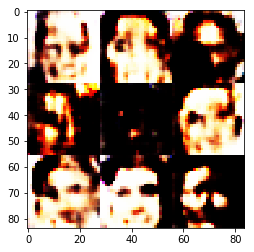

Epoch 1/1... Step 610... Discriminator Loss: 1.2779... Generator Loss: 0.8190
Epoch 1/1... Step 620... Discriminator Loss: 1.2094... Generator Loss: 0.9235
Epoch 1/1... Step 630... Discriminator Loss: 1.2058... Generator Loss: 1.0154
Epoch 1/1... Step 640... Discriminator Loss: 1.2079... Generator Loss: 1.1275
Epoch 1/1... Step 650... Discriminator Loss: 1.2968... Generator Loss: 1.1052
Epoch 1/1... Step 660... Discriminator Loss: 1.0478... Generator Loss: 1.1362
Epoch 1/1... Step 670... Discriminator Loss: 0.9650... Generator Loss: 1.0349
Epoch 1/1... Step 680... Discriminator Loss: 0.8217... Generator Loss: 1.2125
Epoch 1/1... Step 690... Discriminator Loss: 1.0102... Generator Loss: 1.1958
Epoch 1/1... Step 700... Discriminator Loss: 1.0711... Generator Loss: 0.9796
Sample Outputs....


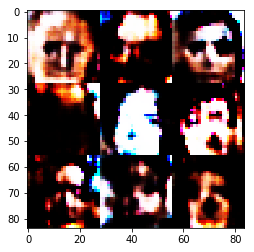

Epoch 1/1... Step 710... Discriminator Loss: 1.2687... Generator Loss: 0.9739
Epoch 1/1... Step 720... Discriminator Loss: 1.2529... Generator Loss: 1.0611
Epoch 1/1... Step 730... Discriminator Loss: 1.3224... Generator Loss: 0.8973
Epoch 1/1... Step 740... Discriminator Loss: 1.3103... Generator Loss: 0.9539
Epoch 1/1... Step 750... Discriminator Loss: 1.3428... Generator Loss: 0.7920
Epoch 1/1... Step 760... Discriminator Loss: 1.3425... Generator Loss: 0.8365
Epoch 1/1... Step 770... Discriminator Loss: 1.3407... Generator Loss: 0.8763
Epoch 1/1... Step 780... Discriminator Loss: 1.2898... Generator Loss: 0.8452
Epoch 1/1... Step 790... Discriminator Loss: 1.3049... Generator Loss: 0.7783
Epoch 1/1... Step 800... Discriminator Loss: 1.3463... Generator Loss: 0.8849
Sample Outputs....


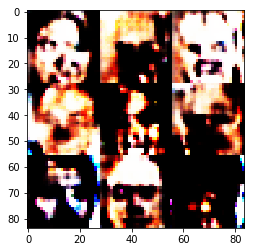

Epoch 1/1... Step 810... Discriminator Loss: 1.3165... Generator Loss: 0.8106
Epoch 1/1... Step 820... Discriminator Loss: 1.3311... Generator Loss: 0.8245
Epoch 1/1... Step 830... Discriminator Loss: 1.3323... Generator Loss: 0.9136
Epoch 1/1... Step 840... Discriminator Loss: 1.3472... Generator Loss: 0.8333
Epoch 1/1... Step 850... Discriminator Loss: 1.3278... Generator Loss: 0.8419
Epoch 1/1... Step 860... Discriminator Loss: 1.3321... Generator Loss: 0.7972
Epoch 1/1... Step 870... Discriminator Loss: 1.3136... Generator Loss: 0.8451
Epoch 1/1... Step 880... Discriminator Loss: 1.3560... Generator Loss: 0.8391
Epoch 1/1... Step 890... Discriminator Loss: 1.3413... Generator Loss: 0.8031
Epoch 1/1... Step 900... Discriminator Loss: 1.3516... Generator Loss: 0.8066
Sample Outputs....


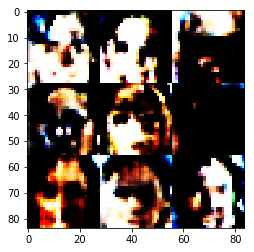

Epoch 1/1... Step 910... Discriminator Loss: 1.3546... Generator Loss: 0.8345
Epoch 1/1... Step 920... Discriminator Loss: 1.3664... Generator Loss: 0.8228
Epoch 1/1... Step 930... Discriminator Loss: 1.3429... Generator Loss: 0.8003
Epoch 1/1... Step 940... Discriminator Loss: 1.3528... Generator Loss: 0.8160
Epoch 1/1... Step 950... Discriminator Loss: 1.3424... Generator Loss: 0.8739
Epoch 1/1... Step 960... Discriminator Loss: 1.3446... Generator Loss: 0.8426
Epoch 1/1... Step 970... Discriminator Loss: 1.3511... Generator Loss: 0.8367
Epoch 1/1... Step 980... Discriminator Loss: 1.3329... Generator Loss: 0.8420
Epoch 1/1... Step 990... Discriminator Loss: 1.3197... Generator Loss: 0.7983
Epoch 1/1... Step 1000... Discriminator Loss: 1.3437... Generator Loss: 0.8364
Sample Outputs....


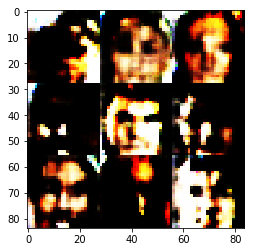

Epoch 1/1... Step 1010... Discriminator Loss: 1.3372... Generator Loss: 0.8833
Epoch 1/1... Step 1020... Discriminator Loss: 1.3369... Generator Loss: 0.8234
Epoch 1/1... Step 1030... Discriminator Loss: 1.3576... Generator Loss: 0.8352
Epoch 1/1... Step 1040... Discriminator Loss: 1.3599... Generator Loss: 0.8185
Epoch 1/1... Step 1050... Discriminator Loss: 1.3436... Generator Loss: 0.8352
Epoch 1/1... Step 1060... Discriminator Loss: 1.3600... Generator Loss: 0.8158
Epoch 1/1... Step 1070... Discriminator Loss: 1.3590... Generator Loss: 0.8238
Epoch 1/1... Step 1080... Discriminator Loss: 1.3510... Generator Loss: 0.8486
Epoch 1/1... Step 1090... Discriminator Loss: 1.3507... Generator Loss: 0.8129
Epoch 1/1... Step 1100... Discriminator Loss: 1.3561... Generator Loss: 0.8106
Sample Outputs....


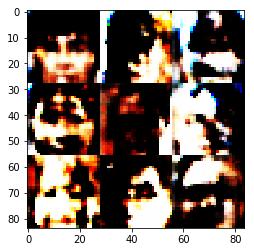

Epoch 1/1... Step 1110... Discriminator Loss: 1.3405... Generator Loss: 0.8402
Epoch 1/1... Step 1120... Discriminator Loss: 1.3300... Generator Loss: 0.8063
Epoch 1/1... Step 1130... Discriminator Loss: 1.3498... Generator Loss: 0.8010
Epoch 1/1... Step 1140... Discriminator Loss: 1.3170... Generator Loss: 0.7964
Epoch 1/1... Step 1150... Discriminator Loss: 1.3542... Generator Loss: 0.8329
Epoch 1/1... Step 1160... Discriminator Loss: 1.3685... Generator Loss: 0.7913
Epoch 1/1... Step 1170... Discriminator Loss: 1.3471... Generator Loss: 0.8686
Epoch 1/1... Step 1180... Discriminator Loss: 1.3601... Generator Loss: 0.8403
Epoch 1/1... Step 1190... Discriminator Loss: 1.3572... Generator Loss: 0.8678
Epoch 1/1... Step 1200... Discriminator Loss: 1.3569... Generator Loss: 0.8244
Sample Outputs....


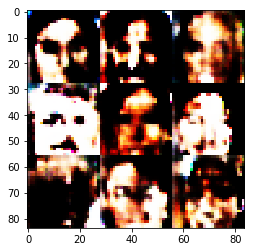

Epoch 1/1... Step 1210... Discriminator Loss: 1.3372... Generator Loss: 0.8312
Epoch 1/1... Step 1220... Discriminator Loss: 1.3575... Generator Loss: 0.8378
Epoch 1/1... Step 1230... Discriminator Loss: 1.3547... Generator Loss: 0.8633
Epoch 1/1... Step 1240... Discriminator Loss: 1.3574... Generator Loss: 0.7925
Epoch 1/1... Step 1250... Discriminator Loss: 1.3426... Generator Loss: 0.8221
Epoch 1/1... Step 1260... Discriminator Loss: 1.3514... Generator Loss: 0.8475
Epoch 1/1... Step 1270... Discriminator Loss: 1.3585... Generator Loss: 0.8194
Epoch 1/1... Step 1280... Discriminator Loss: 1.3569... Generator Loss: 0.8663
Epoch 1/1... Step 1290... Discriminator Loss: 1.3370... Generator Loss: 0.8572
Epoch 1/1... Step 1300... Discriminator Loss: 1.3565... Generator Loss: 0.8227
Sample Outputs....


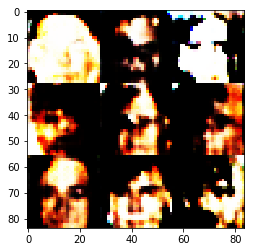

Epoch 1/1... Step 1310... Discriminator Loss: 1.3496... Generator Loss: 0.8030
Epoch 1/1... Step 1320... Discriminator Loss: 1.3458... Generator Loss: 0.7981
Epoch 1/1... Step 1330... Discriminator Loss: 1.3588... Generator Loss: 0.8109
Epoch 1/1... Step 1340... Discriminator Loss: 1.3566... Generator Loss: 0.8312
Epoch 1/1... Step 1350... Discriminator Loss: 1.3399... Generator Loss: 0.8109
Epoch 1/1... Step 1360... Discriminator Loss: 1.3586... Generator Loss: 0.8590
Epoch 1/1... Step 1370... Discriminator Loss: 1.3410... Generator Loss: 0.8574
Epoch 1/1... Step 1380... Discriminator Loss: 1.3437... Generator Loss: 0.8463
Epoch 1/1... Step 1390... Discriminator Loss: 1.3581... Generator Loss: 0.8167
Epoch 1/1... Step 1400... Discriminator Loss: 1.3503... Generator Loss: 0.8541
Sample Outputs....


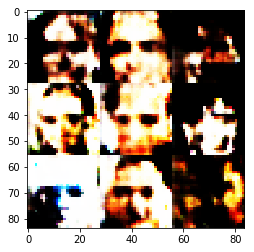

Epoch 1/1... Step 1410... Discriminator Loss: 1.3727... Generator Loss: 0.8448
Epoch 1/1... Step 1420... Discriminator Loss: 1.3562... Generator Loss: 0.8413
Epoch 1/1... Step 1430... Discriminator Loss: 1.3513... Generator Loss: 0.8293
Epoch 1/1... Step 1440... Discriminator Loss: 1.3452... Generator Loss: 0.8737
Epoch 1/1... Step 1450... Discriminator Loss: 1.3485... Generator Loss: 0.8248
Epoch 1/1... Step 1460... Discriminator Loss: 1.3530... Generator Loss: 0.7937
Epoch 1/1... Step 1470... Discriminator Loss: 1.3618... Generator Loss: 0.8213
Epoch 1/1... Step 1480... Discriminator Loss: 1.3563... Generator Loss: 0.8251
Epoch 1/1... Step 1490... Discriminator Loss: 1.3529... Generator Loss: 0.8030
Epoch 1/1... Step 1500... Discriminator Loss: 1.3515... Generator Loss: 0.8145
Sample Outputs....


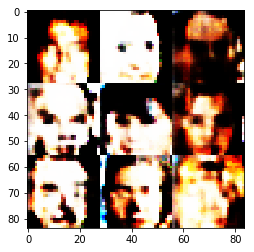

Epoch 1/1... Step 1510... Discriminator Loss: 1.3379... Generator Loss: 0.8595
Epoch 1/1... Step 1520... Discriminator Loss: 1.3283... Generator Loss: 0.8290
Epoch 1/1... Step 1530... Discriminator Loss: 1.3548... Generator Loss: 0.8269
Epoch 1/1... Step 1540... Discriminator Loss: 1.3658... Generator Loss: 0.8091
Epoch 1/1... Step 1550... Discriminator Loss: 1.3605... Generator Loss: 0.8076
Epoch 1/1... Step 1560... Discriminator Loss: 1.3547... Generator Loss: 0.8142
Epoch 1/1... Step 1570... Discriminator Loss: 1.3501... Generator Loss: 0.8070
Epoch 1/1... Step 1580... Discriminator Loss: 1.3472... Generator Loss: 0.7955


In [43]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.